# Sentiment Analysis of Financial News

The data source is available at [Kaggle](https://www.kaggle.com/datasets/ankurzing/sentiment-analysis-for-financial-news?resource=download). 

**Context**: This dataset (FinancialPhraseBank) contains the sentiments for financial news headlines from the perspective of a retail investor.

This time we try to use DistilBERT Embeddings with LSTM.

In [1]:
import plot_pie

import time
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
# nltk.download('stopwords')
# nltk.download('punkt')

import transformers # transformers library by Hugging Face
from transformers import MarianMTModel, pipeline

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence


# from torchtext.vocab import GloVe
# from torchtext.data.utils import get_tokenizer

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay,  precision_score, recall_score, f1_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

from textblob import TextBlob

import string

import pickle
import joblib

We first do a GPU check.

In [2]:
print(torch.version.cuda)
print(torch.cuda.is_available())  # Should return True if CUDA is available
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(torch.cuda.current_device()))

12.4
True
1
0
NVIDIA GeForce GTX 960M


In [3]:
os.getcwd()

'D:\\Data\\PyCharmProjects\\MAS-sentiment-analysis\\sent_analysis'

In [4]:
data = pd.read_csv("D:\Data\PyCharmProjects\MAS-sentiment-analysis\data/balanced_all_clean_v1.csv")
data.dropna(inplace=True)
# Encode the sentiment labels to integers
label_encoder = LabelEncoder()
data['sentiment_encoded'] = label_encoder.fit_transform(data['sentiment'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8020 entries, 0 to 8020
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   sentiment          8020 non-null   object
 1   news               8020 non-null   object
 2   sentiment_encoded  8020 non-null   int32 
dtypes: int32(1), object(2)
memory usage: 219.3+ KB


# Model

## DistilBERT & LSTM

The DistilBERT processes the input sentence and passes on the relevant information to the LSTM Model for sentiment classification. 

Define the LSTM Classifier:

The LSTM classifier will take the DistilBERT embeddings (shape: [batch_size, seq_len, hidden_dim], i.e., [8020, 150, 768]) as input.

In [5]:
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (transformers.DistilBertModel,
                                                    transformers.DistilBertTokenizer,
                                                    'distilbert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

# tokenize all the reviews in column 0 of the dataframe "df"
tokenized = data['news'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))



In [6]:
def visualized_sentence_embedding(df: pd.DataFrame, tokenized: pd.Series) -> pd.DataFrame:
    """
    Function to see tokens and embeddings of the first review in df.
    """
    tokens = data.iloc[0,1].split(" ")
    tokens.insert(0, "CLS")
    tokens.append("SEP")
    assert len(tokens) == len(tokenized[0])
    token_embeddings = list(zip(tokens, tokenized[0]))
    df_token_embeddings = pd.DataFrame(token_embeddings, columns=["Tokens", "Embeddings"])
    return df_token_embeddings

df_token_embeddings = visualized_sentence_embedding(data, tokenized)
df_token_embeddings.head(500)

,Tokens,Embeddings
0,CLS,101
1,According,2429
2,to,2000
3,Gran,12604
4,",",1010
5,the,1996
6,company,2194
7,has,2038
8,no,2053
9,plans,3488


In [7]:
max_len = 0
max_len = max([len(i) for i in tokenized.values if len(i) > max_len])
padded_token_embeddings = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
print(max_len)
print(padded_token_embeddings.shape)

attention_mask = np.where(padded_token_embeddings != 0, 1, 0)
assert attention_mask.shape == padded_token_embeddings.shape
print(attention_mask.shape)

150
(8020, 150)
(8020, 150)


In [8]:
# move model and data to gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

torch.cuda.empty_cache()

model.to(device)  # Move the model to the GPU

cuda


DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li

In [9]:
batch_size = 8  # Adjust this to a smaller number that fits your GPU memory

input_ids = torch.tensor(padded_token_embeddings)
attention_mask = torch.tensor(attention_mask)

# Assuming you have your input_ids and attention_mask tensors
input_ids_batches = torch.split(input_ids, batch_size)
attention_mask_batches = torch.split(attention_mask, batch_size)

In [10]:
last_hidden_states = []
start = time.time()

with torch.no_grad():
    for input_ids_batch, attention_mask_batch in zip(input_ids_batches, attention_mask_batches):
        outputs = model(input_ids_batch.to(device), attention_mask=attention_mask_batch.to(device))
        last_hidden_states.append(outputs[0].cpu())  # Move outputs to CPU to free GPU memory

end = time.time()
print(round((end - start)/60, 2), 'minutes') # time in minutes
last_hidden_states = torch.cat(last_hidden_states, dim=0)

2.59 minutes


In [11]:
last_hidden_states.shape

torch.Size([8020, 150, 768])

In [48]:
# extracting features and labels
# features = last_hidden_states[:,0,:].numpy()
features = last_hidden_states
print(features.shape)

torch.Size([8020, 150, 768])


In [49]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)  # LSTM output
        lstm_out = self.dropout(lstm_out[:, -1, :])  # Use the last hidden state
        out = self.fc(lstm_out)  # Fully connected layer for classification
        return out

In [50]:
# Set dimensions for LSTM
hidden_dim = 128  # Number of hidden units in the LSTM
output_dim = 3    # Number of sentiment classes: Positive, Neutral, Negative
input_dim = 768   # Match DistilBERT's hidden size

# Initialize LSTM classifier
lstm_model = LSTMClassifier(input_dim, hidden_dim, output_dim)

In [51]:
labels = data['sentiment_encoded']
assert len(features) == len(labels)

In [52]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.2, random_state=42)

In [53]:
# Convert data to DataLoader format
from torch.utils.data import DataLoader, TensorDataset
import torch

batch_size = 32

In [56]:
train_labels_array = train_labels.to_numpy()  # or use train_labels.values
test_labels_array = test_labels.to_numpy()

# Convert labels to tensors with dtype=torch.long
train_dataset = TensorDataset(train_features, torch.tensor(train_labels_array, dtype=torch.long))
test_dataset = TensorDataset(test_features, torch.tensor(test_labels_array, dtype=torch.long))

print("Datasets created successfully.")

Datasets created successfully.


In [57]:
# # Convert tensors
# train_dataset = TensorDataset(train_features, torch.tensor(train_labels, dtype=torch.long))
# test_dataset = TensorDataset(test_features, torch.tensor(test_labels, dtype=torch.long))

In [58]:
# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Training the LSTM model

In [60]:
%%timeit
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lstm_model.to(device)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    lstm_model.train()
    epoch_loss = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = lstm_model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    # Print only for the first epoch and every 10 epochs
    if epoch == 0 or (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}')


Epoch 1/100, Loss: 0.2074
Epoch 10/100, Loss: 0.0687
Epoch 20/100, Loss: 0.0405
Epoch 30/100, Loss: 0.0250
Epoch 40/100, Loss: 0.0135
Epoch 50/100, Loss: 0.0147
Epoch 60/100, Loss: 0.0304
Epoch 70/100, Loss: 0.0218
Epoch 80/100, Loss: 0.0195
Epoch 90/100, Loss: 0.0148
Epoch 100/100, Loss: 0.0219
Epoch 1/100, Loss: 0.0139
Epoch 10/100, Loss: 0.0153
Epoch 20/100, Loss: 0.0224
Epoch 30/100, Loss: 0.0089
Epoch 40/100, Loss: 0.0079
Epoch 50/100, Loss: 0.0012
Epoch 60/100, Loss: 0.0155
Epoch 70/100, Loss: 0.0252
Epoch 80/100, Loss: 0.0031
Epoch 90/100, Loss: 0.0029
Epoch 100/100, Loss: 0.0015
Epoch 1/100, Loss: 0.0159
Epoch 10/100, Loss: 0.0017
Epoch 20/100, Loss: 0.0102
Epoch 30/100, Loss: 0.0027
Epoch 40/100, Loss: 0.0010
Epoch 50/100, Loss: 0.0011
Epoch 60/100, Loss: 0.0014
Epoch 70/100, Loss: 0.0079
Epoch 80/100, Loss: 0.0196
Epoch 90/100, Loss: 0.0005
Epoch 100/100, Loss: 0.0168
Epoch 1/100, Loss: 0.0064
Epoch 10/100, Loss: 0.0009
Epoch 20/100, Loss: 0.0009
Epoch 30/100, Loss: 0.0049
Ep

In [61]:
print("ran in 1hr 20mins")

ran in 1hr 20mins


Evaluate the LSTM model

In [74]:
print(lstm_model)

LSTMClassifier(
  (lstm): LSTM(768, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [72]:
from sklearn.metrics import accuracy_score, classification_report

lstm_model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = lstm_model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


In [71]:
# Calculate accuracy
accuracy = accuracy_score(all_labels, all_predictions)
print(f"Test Accuracy: {accuracy:.4f}")

# Detailed classification report
print(classification_report(all_labels, all_predictions, target_names=['Negative', 'Neutral', 'Positive']))

Test Accuracy: 0.8510
              precision    recall  f1-score   support

    Negative       0.91      0.90      0.91       492
     Neutral       0.83      0.84      0.84       567
    Positive       0.82      0.81      0.82       545

    accuracy                           0.85      1604
   macro avg       0.85      0.85      0.85      1604
weighted avg       0.85      0.85      0.85      1604



In [67]:
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='weighted')

In [68]:
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Test Accuracy: 0.8510
Precision: 0.8511
Recall: 0.8510
F1 Score: 0.8510


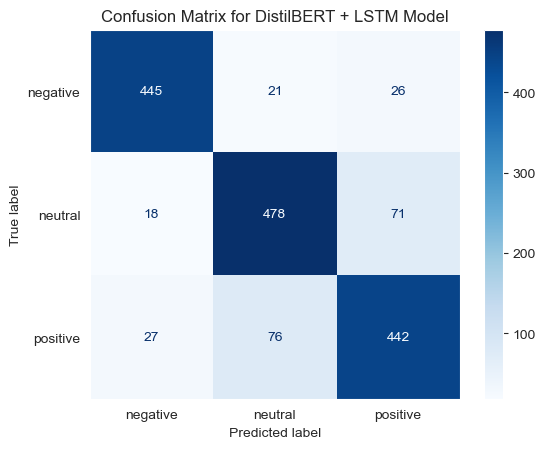

In [73]:
# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=lr_best.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['negative',  'neutral', 'positive'])
disp.plot(cmap='Blues')
# Remove gridlines
plt.grid(False)
plt.title('Confusion Matrix for DistilBERT + LSTM Model')
plt.show()

## 4. Naive Bayes Model

In [75]:
# Preprocess the text data
def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text.lower())
    # Remove punctuation
    tokens = [word for word in tokens if word.isalpha()]
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

In [76]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8020 entries, 0 to 8020
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   sentiment          8020 non-null   object
 1   news               8020 non-null   object
 2   sentiment_encoded  8020 non-null   int32 
dtypes: int32(1), object(2)
memory usage: 477.3+ KB


In [77]:
data['processed_news'] = data['news'].apply(preprocess_text)

In [80]:
data.processed_news[0]

'according gran company plans move production russia although company growing'

In [81]:
# Convert text data into numerical features
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data['processed_news'])
y = data['sentiment']

In [84]:
print(X[0])

  (0, 65)	1
  (0, 4040)	1
  (0, 1780)	2
  (0, 7267)	1
  (0, 6292)	1
  (0, 7562)	1
  (0, 8437)	1
  (0, 364)	1
  (0, 4097)	1


In [87]:
# Get the first processed news
first_news = [data['processed_news'][0]]

# Transform the first news entry using the CountVectorizer
first_news_vectorized = vectorizer.transform(first_news)

# Get the feature names (words)
feature_names = vectorizer.get_feature_names_out()

# Convert the sparse matrix to a dense array
first_news_dense = first_news_vectorized.toarray()

# Create a DataFrame to display word frequencies
first_news_df = pd.DataFrame(first_news_dense, columns=feature_names)

# Display non-zero frequencies
non_zero_features = first_news_df.loc[:, (first_news_df != 0).any(axis=0)]
print(non_zero_features)


   according  although  company  gran  growing  move  plans  production  \
0          1         1        2     1        1     1      1           1   

   russia  
0       1  


In [88]:
non_zero_features

,according,although,company,gran,growing,move,plans,production,russia
0,1,1,2,1,1,1,1,1,1
